In [1]:
using CSV
using Turing
using NNlib: softmax
using Queryverse
using StatsPlots

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278
┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1278
┌ Info: Precompiling Queryverse [612083be-0b0f-5412-89c1-4e7c75506a58]
└ @ Base loading.jl:1278
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278


In [2]:
d = CSV.read(download("https://raw.githubusercontent.com/dviera/marketing-analytics/master/conditional_logit/data/candy.csv"));

In [3]:
# Dark column name has a whitespace
rename!(d, rstrip.(names(d)));

In [4]:
X = Dict()
for i in 1:maximum(d.id)
    X[i] = d |> @filter(_.id == i) |> @select(:Dark, :Soft, :Nuts) |> DataFrame
end

In [5]:
X[1]

,Dark,Soft,Nuts
,Int64,Int64,Int64
1,0,0,0
2,0,0,1
3,0,1,0
4,0,1,1
5,1,0,0
6,1,0,1
7,1,1,0
8,1,1,1


In [6]:
y = d |> @select(:id, :Alt, :Choose) |> @filter(_.Choose != 0) |> @select(:Alt) |> DataFrame

,Alt
,Int64
1,2
2,2
3,5
4,5
5,6
6,6
7,6
8,6
9,6


In [7]:
@model conLogit(y, X) = begin
    nObs = size(y, 1)
    nFeat = size(X[1], 2)
    
    beta1 ~ Normal(0, 10)
    beta2 ~ Normal(0, 10)
    beta3 ~ Normal(0, 10)
    
    
    for i in 1:nObs
        # all the X are the same
        mu = X[i][:, 1] * beta1 + X[i][:, 2] * beta2 + X[i][:, 3] * beta3
        v = softmax(mu)
        y[i] ~ Categorical(v)
    end
    
end

conLogit (generic function with 1 method)

In [8]:
Turing.setadbackend(:reverse_diff)
model = conLogit(Matrix(y), X);
chain = sample(model, NUTS(0.65), 10_000)

┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\2l209\src\inference\hmc.jl:625
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:16


Chains MCMC chain (9000×15×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = beta1, beta2, beta3
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat  
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64  
                                                                              
       beta1    1.5867    0.8774     0.0092    0.0109    6067.8099    1.0000  
       beta2   -2.6452    1.2752     0.0134    0.0155    6820.7470    1.0001  
       beta3    0.9561    0.7395     0.0078    0.0067   10057.7319    0.9999  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float6

### Analysis of the results

1) Dark is preferred to Milk -> 1.58

2) Chewy is preferred to Soft -> -2.67

3) Nuts is preferred to No Nuts -> 0.95

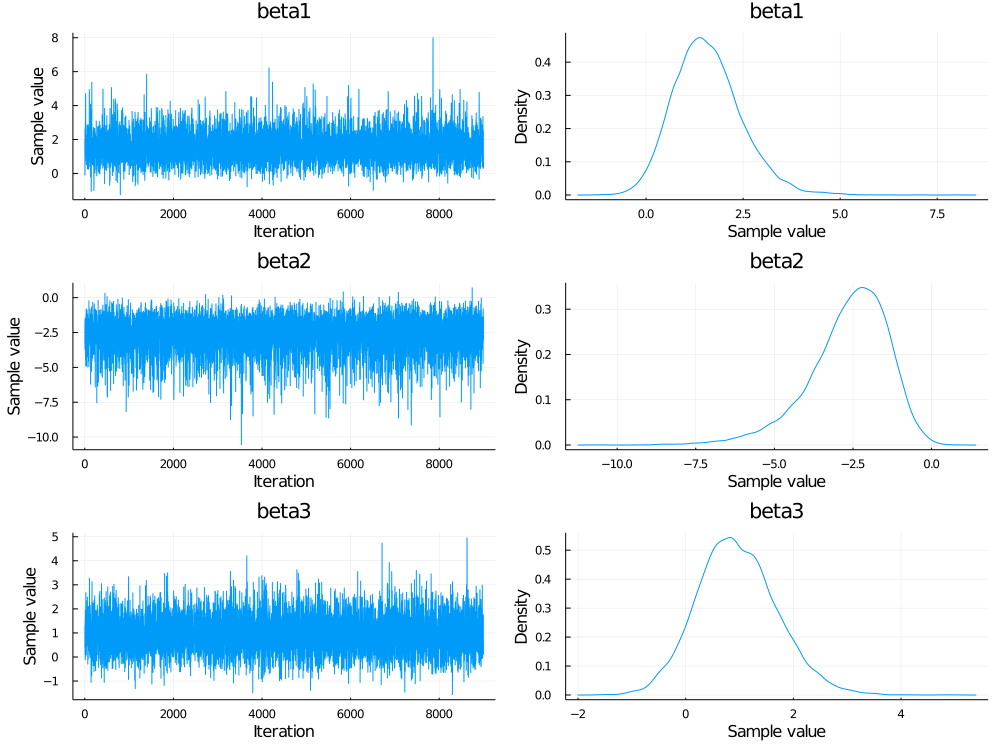

In [9]:
plot(chain)

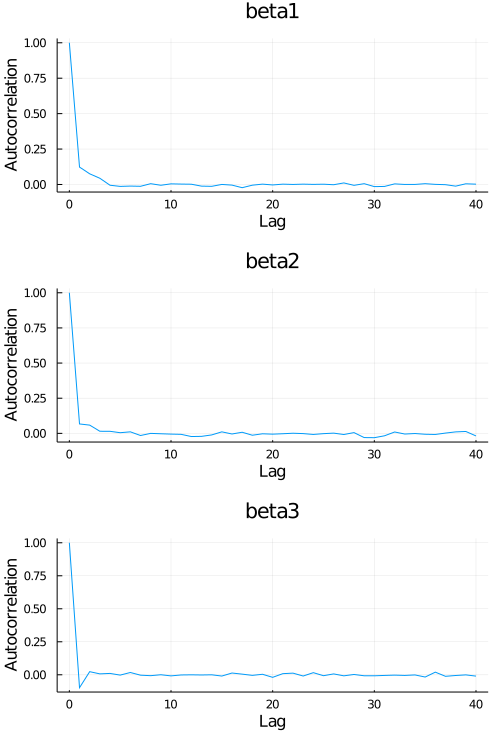

In [10]:
autocorplot(chain)

In [11]:
d |> Voyager()

Voyager(Electron.Window(Application(Base.PipeEndpoint(Base.Libc.WindowsRawSocket(0x0000000000000450) open, 0 bytes waiting), Process(`'C:\Users\User\.julia\artifacts\3cac82ef60c809398a5dd6870b5e97d42dbe2df1\electron.exe' 'C:\Users\User\.julia\packages\Electron\MNI24\src\main.js' '\\.\pipe\jlel-108402000cb611eb2462590baf02b719' '\\.\pipe\jlel-sn-108429120cb611eb3dd7dd3516f0384a' 8911SRmB1sE4+dRJw8v2+AoMeZOY+gGHgql4hs5hNHRSs0MD5X0dCqLumWWHHjdY8vnpQEBTtbjXj/WYz04cXKZ62HbKFP5nBjkd1RK+KFUM5QzXET4FGfJKdTTzeSnUS36mjQkLwuz8UPzKUZE6ZOdkrin4MJbyuuLg+AkVY8c=`, ProcessRunning), [1 window]), 1, true, Channel{Any}(sz_max:128,sz_curr:0)))

In [12]:
names(chain)

15-element Array{Symbol,1}:
 :acceptance_rate
 :beta1
 :beta2
 :beta3
 :hamiltonian_energy
 :hamiltonian_energy_error
 :is_accept
 :log_density
 :lp
 :max_hamiltonian_energy_error
 :n_steps
 :nom_step_size
 :numerical_error
 :step_size
 :tree_depth

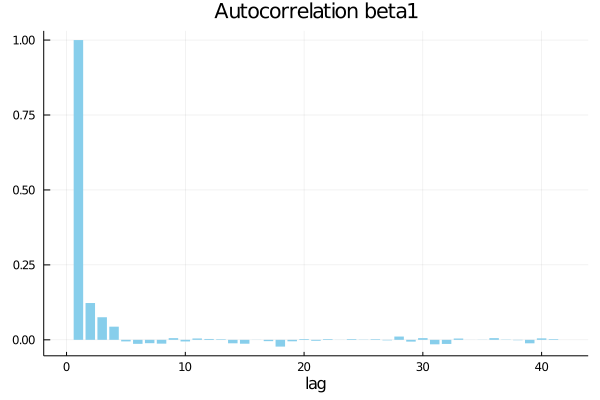

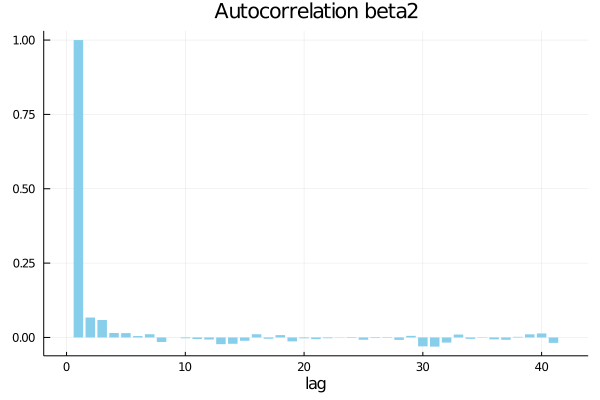

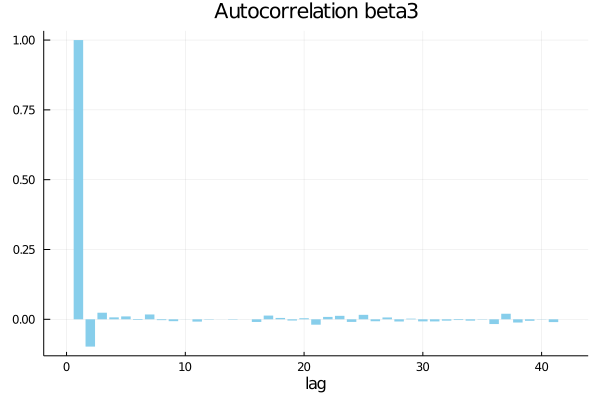

In [13]:
using Plots
be = ["beta1", "beta2", "beta3"]

for i in be
    acf = autocor(chain[i])
    display(plot(bar(acf, title = "Autocorrelation $(i)", legend = false),  linecolor = nothing, fillcolor = :skyblue, xlabel = "lag"))   
end

In [14]:
utility = Matrix(X[1]) * [mean(chain[:beta1]), mean(chain[:beta2]), mean(chain[:beta3])]
prob_choice = exp.(utility) ./ sum(exp.(utility))
prob_df = d |> @filter(_.id == 1) |> @select(:Choice) |> DataFrame
prob_df["Prob %"] =  prob_choice * 100
prob_df

,Choice,Prob %
,String,Float64
1,c1,4.40353
2,c2,11.4561
3,c3,0.312605
4,c4,0.813264
5,c5,21.5217
6,c6,55.9902
7,c7,1.52782
8,c8,3.97472


In [15]:
d |> @filter(_.id == 1 && _.Choice in ("c6", "c5")) 

id,Choice,Choose,Alt,Dark,Soft,Nuts
1,"""c5""",0,5,1,0,0
1,"""c6""",0,6,1,0,1
